<a href="https://colab.research.google.com/github/qamtam/Hands-on-machine-learning/blob/main/CH16_SET10_with_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

In [ ]:
#data prep game plan
#1 add a start (<sos>), end (<eos>) token 
#2 clean the sentences with removing all special characters
#3 embed the word index and reverse word index (word -> id) and (id -> word)
#4 pad the sentences to max length


In [ ]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [ ]:
# Convert the unicode file to ascii

def unicode_to_ascii(s):
  # print(s)
  # print(''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')) visibly identical
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn') #mn is a 'nonspacing mark' category like the ` above a in a la


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  
  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)


  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(preprocess_sentence(sp_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start>  ¿ puedo tomar prestado este libro ?  <end>
b'<start>  \xc2\xbf puedo tomar prestado este libro ?  <end>'


In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n') # otwórz, przeczytaj, usuń nadmiarowe spacje, oddzielamy enterem i te oddzielone ładujemy do jednej zmiennej
  #print(lines[55]) ## No way!	De ninguna manera.

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]] # tabulator oddziela angielski od hiszpańskiego

  return zip(*word_pairs) 
  #* to operator unzippowania! -> mamy zatem jedną krotkę (en, sp) w której każdy element jest listą słów, a wyrażenia mogą być dłuższe (he is mean)
  '''
>>> letters = ['b', 'a', 'd', 'c']
>>> numbers = [2, 4, 3, 1]
>>> data = sorted(zip(letters, numbers))  # Sort by letters
>>> data
[('a', 4), ('b', 2), ('c', 1), ('d', 3)]

>>> pairs = [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]
>>> numbers, letters = zip(*pairs)
>>> numbers
(1, 2, 3, 4)
>>> letters
('a', 'b', 'c', 'd')
'''


In [ ]:

en, sp = create_dataset(path_to_file, None)
print(en[:20])
print(sp[:20])

Go.	Vaya.
('<start> go .  <end>', '<start> go .  <end>', '<start> go .  <end>', '<start> go .  <end>', '<start> hi .  <end>', '<start> run !  <end>', '<start> run .  <end>', '<start> who ?  <end>', '<start> fire !  <end>', '<start> fire !  <end>', '<start> fire !  <end>', '<start> help !  <end>', '<start> help !  <end>', '<start> help !  <end>', '<start> jump !  <end>', '<start> jump .  <end>', '<start> stop !  <end>', '<start> stop !  <end>', '<start> stop !  <end>', '<start> wait !  <end>')
('<start> ve .  <end>', '<start> vete .  <end>', '<start> vaya .  <end>', '<start> vayase .  <end>', '<start> hola .  <end>', '<start>  corre !  <end>', '<start> corred .  <end>', '<start>  ¿ quien ?  <end>', '<start>  fuego !  <end>', '<start>  incendio !  <end>', '<start>  disparad !  <end>', '<start>  ayuda !  <end>', '<start>  socorro ! auxilio !  <end>', '<start>  auxilio !  <end>', '<start>  salta !  <end>', '<start> salte .  <end>', '<start>  parad !  <end>', '<start>  para !  <end>', '<sta

In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='') # pusty tokenizator
  lang_tokenizer.fit_on_texts(lang)
  # stwórz id dla słów w tekście (dopasowanie tokenizatora)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  # dummy tensor na pojedynczych słowach języka (go => 1 stay => 2  etc). Pasuje też do całych zdań, ale tu zdań nie ma, zatem równie dobrze mozna to nazwać words_to_numbers czy coś
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  # wyrównanie długości elementów tensora do najdłuższego

  return tensor, lang_tokenizer


def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [ ]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [ ]:
#tf.data

BUFFER_SIZE = len(input_tensor_train) #rozmiar bufora do przemieszania, przemiesza oczywiście jednocześnie odpowiednie pary zachowując sens
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1 # inp_lang to sam tokenizer, word index to dict {'una' : 21, ... }
vocab_tar_size = len(targ_lang.word_index)+1
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
inp_lang.word_index

{'<start>': 1,
 '<end>': 2,
 '.': 3,
 'tom': 4,
 '?': 5,
 '¿': 6,
 'es': 7,
 'no': 8,
 'el': 9,
 'a': 10,
 'que': 11,
 'me': 12,
 'la': 13,
 'de': 14,
 'un': 15,
 'esta': 16,
 'se': 17,
 'lo': 18,
 'mi': 19,
 'en': 20,
 'una': 21,
 'por': 22,
 'te': 23,
 'estoy': 24,
 'ella': 25,
 'yo': 26,
 '!': 27,
 'eso': 28,
 'le': 29,
 'esto': 30,
 'tu': 31,
 ',': 32,
 'los': 33,
 'aqui': 34,
 'soy': 35,
 'muy': 36,
 'tengo': 37,
 'puedo': 38,
 'las': 39,
 'gusta': 40,
 'mary': 41,
 'tiene': 42,
 'son': 43,
 'con': 44,
 'como': 45,
 'quien': 46,
 'estaba': 47,
 'su': 48,
 'este': 49,
 'favor': 50,
 'estas': 51,
 'eres': 52,
 'quiero': 53,
 'ellos': 54,
 'fue': 55,
 'bien': 56,
 'casa': 57,
 'ahora': 58,
 'tomas': 59,
 'donde': 60,
 'mas': 61,
 'estan': 62,
 'nos': 63,
 'he': 64,
 'solo': 65,
 'puede': 66,
 'ha': 67,
 'era': 68,
 'todos': 69,
 'al': 70,
 'para': 71,
 'ir': 72,
 'tan': 73,
 'todo': 74,
 'estamos': 75,
 'necesito': 76,
 'ya': 77,
 'nadie': 78,
 'puedes': 79,
 'trabajo': 80,
 'voy': 8

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))

In [ ]:
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

IndentationError: ignored

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)# embed nowego inputu
    self.gru = tf.keras.layers.GRU(self.enc_units,  #1024 jednostki --> 1024 hidden state'y
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))
'''
dotyczy calla
>>> inputs = tf.random.normal([32, 10, 8])
>>> gru = tf.keras.layers.GRU(4)
>>> output = gru(inputs)
>>> print(output.shape)
(32, 4)
>>> gru = tf.keras.layers.GRU(4, return_sequences=True, return_state=True)
>>> whole_sequence_output, final_state = gru(inputs)
>>> print(whole_sequence_output.shape)
(32, 10, 4)
>>> print(final_state.shape)
(32, 4)
'''


'\ndotyczy calla\n>>> inputs = tf.random.normal([32, 10, 8])\n>>> gru = tf.keras.layers.GRU(4)\n>>> output = gru(inputs)\n>>> print(output.shape)\n(32, 4)\n>>> gru = tf.keras.layers.GRU(4, return_sequences=True, return_state=True)\n>>> whole_sequence_output, final_state = gru(inputs)\n>>> print(whole_sequence_output.shape)\n(32, 10, 4)\n>>> print(final_state.shape)\n(32, 4)\n'

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    #query == hidden state (64*1024) # CHUJ # QUERY to nasz poprzedni stan Z DEKODERA
    #pamiętajmy, że warstwa attention znajduje się pomiędzy enkoderem i dekoderem
    #? dla naszego zapytania chcemy znaleźć odpowiednie wagi
    print(query.shape)
    print(values.shape) # values to kurwa cały output enkodera i porównujemy każdą edycję (i. e. słowo jeden, słowo dwa etc) z naszym query
    # values shape == batch_size, max_len, hidden_size # whole_seq_output
    # robimy to żeby dodawanie działało wzdłuż osi czasu
    query_with_time_axis = tf.expand_dims(query, 1)
        # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values))) #score podobieństwa
    
    #attentioon_weights shape == batch, max_length, 1
    attention_weights = tf.nn.softmax(score, axis=1) #na każde słowo jeden wynik


    #context vector shape after sum == batch_size, hidden_size
    context_vector = attention_weights * values
    print(context_vector.shape)
    print(context_vector)
    context_vector = tf.reduce_sum(context_vector, axis=1) #redukujemy wymiar czasu poprzez sumę żeby wyszedł finalny hidden input dla dekodera
    print(context_vector.shape)
    print(context_vector)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

In [ ]:
vocab_inp_size

9414

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    # attention as the first part of a decoder
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
   
    context_vector, attention_weights = self.attention(hidden, enc_output)
 # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    print(x.shape)
     # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # bez expand_dims concat nie zadziała, bo x jest dwuwymiarowe
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # print(output.shape) 64, 1, 1024
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    #  print(output.shape) 64 1024 only one is required for the next word
    x = self.fc(output)
    # x output shape == (batch_size, vocab)   
    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

(64, 1024)
(64, 16, 1024)
(64, 16, 1024)
tf.Tensor(
[[[-1.19145050e-04 -3.09461728e-04 -2.34913587e-05 ... -5.20101050e-04
    1.68339291e-04  4.43701545e-04]
  [-1.08849905e-04  2.34860527e-05 -1.14163803e-03 ... -3.57993209e-04
   -7.04493199e-04  3.37160687e-04]
  [-2.93444813e-04 -4.13618400e-04 -4.54432855e-04 ... -4.66872705e-04
   -2.69289420e-04  2.60997447e-04]
  ...
  [-6.97062351e-04  1.26735563e-03 -1.53202331e-04 ... -8.82288208e-04
   -5.41010173e-04 -7.95011467e-04]
  [-7.04822654e-04  1.27379550e-03 -1.54258596e-04 ... -8.83791537e-04
   -5.29915560e-04 -7.88998790e-04]
  [-7.09088519e-04  1.27685943e-03 -1.54465233e-04 ... -8.84577166e-04
   -5.23323775e-04 -7.84255681e-04]]

 [[-1.19260985e-04 -3.09762836e-04 -2.35142179e-05 ... -5.20607107e-04
    1.68503102e-04  4.44133300e-04]
  [ 4.29664178e-05 -9.24113992e-05 -6.09251612e-04 ... -4.52154258e-04
    2.12182476e-05 -4.79535927e-04]
  [ 3.41144856e-04  4.20737895e-04  2.24618598e-05 ...  1.26977829e-04
   -2.0302442

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) #jeśli mamy 0 w teście to fałsz
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask  #ignorujemy wszystkie straty poza niezerowymi

  return tf.reduce_mean(loss_) # średnia w batchu




In [ ]:
#checkpoints

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

Pass the input through the encoder which return encoder output and the encoder hidden state.







The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.

The decoder returns the predictions and the decoder hidden state.

The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.

Use teacher forcing to decide the next input to the decoder.

Teacher forcing is the technique where the target word is passed as the next input to the decoder.


The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden # first hidden state of the decoder

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)  # 64 tokeny startowe w batchu, rozmiar (64, 1) żeby pasowało

    #Teacher forcing - we use the proper word target as the nexct input

    for t in range(1, targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output) # pass full enc_output to the decoder

      loss += loss_function(targ[:, t], predictions)

      # use teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1) #używamy poprzedniego prawidłowego słowa jako jedyny input dekodera oprócz hidden state'u

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables)) #iterable

  return batch_loss




In [ ]:
EPOCHS = 10
for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    
    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
   # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start)) 


(64, 1024)
(64, 16, 1024)
(64, 16, 1024)
Tensor("decoder_1/bahdanau_attention_3/mul:0", shape=(64, 16, 1024), dtype=float32)
(64, 1024)
Tensor("decoder_1/bahdanau_attention_3/Sum:0", shape=(64, 1024), dtype=float32)
(64, 1, 256)
(64, 1, 1024)
(64, 1024)
(64, 1024)
(64, 16, 1024)
(64, 16, 1024)
Tensor("decoder_1/bahdanau_attention_3/mul_1:0", shape=(64, 16, 1024), dtype=float32)
(64, 1024)
Tensor("decoder_1/bahdanau_attention_3/Sum_1:0", shape=(64, 1024), dtype=float32)
(64, 1, 256)
(64, 1, 1024)
(64, 1024)
(64, 1024)
(64, 16, 1024)
(64, 16, 1024)
Tensor("decoder_1/bahdanau_attention_3/mul_2:0", shape=(64, 16, 1024), dtype=float32)
(64, 1024)
Tensor("decoder_1/bahdanau_attention_3/Sum_2:0", shape=(64, 1024), dtype=float32)
(64, 1, 256)
(64, 1, 1024)
(64, 1024)
(64, 1024)
(64, 16, 1024)
(64, 16, 1024)
Tensor("decoder_1/bahdanau_attention_3/mul_3:0", shape=(64, 16, 1024), dtype=float32)
(64, 1024)
Tensor("decoder_1/bahdanau_attention_3/Sum_3:0", shape=(64, 1024), dtype=float32)
(64, 1, 25

In [ ]:

def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)
 

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ') if i!= '']

  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot
#small function for plotting the weights

def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1,1,1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize' : 14}
  ax.set_xticklabels([''] + sentence, fontdict = fontdict, rotation = 90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict = fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

(1, 1024)
(1, 16, 1024)
(1, 16, 1024)
tf.Tensor(
[[[-9.6210465e-07  6.2916019e-09 -6.3378172e-07 ... -3.9125649e-07
   -1.4924718e-06  2.4322966e-07]
  [-1.5289286e-05  3.3064836e-07 -6.0511047e-06 ... -3.2141074e-07
   -1.9807909e-05  6.7256315e-06]
  [-1.4264396e-03  2.2601102e-05 -8.9595234e-04 ... -2.2888156e-05
    7.9119101e-04  2.9270656e-03]
  ...
  [-4.8266254e-02  5.5627839e-04 -5.2366168e-03 ... -7.6523318e-04
    9.2480816e-02  7.3146850e-02]
  [-5.2094996e-02  5.5120222e-04 -5.2613905e-03 ... -7.7673432e-04
    9.1919430e-02  7.2702937e-02]
  [-5.5653282e-02  5.4680416e-04 -5.2892133e-03 ... -7.8898412e-04
    9.1465883e-02  7.2343975e-02]]], shape=(1, 16, 1024), dtype=float32)
(1, 1024)
tf.Tensor(
[[-0.40702066  0.00606882 -0.0571375  ... -0.00783724  0.8754614
   0.79081166]], shape=(1, 1024), dtype=float32)
(1, 1, 256)
(1, 1, 1024)
(1, 1024)
(1, 1024)
(1, 16, 1024)
(1, 16, 1024)
tf.Tensor(
[[[-5.0754985e-03  3.3190794e-05 -3.3434597e-03 ... -2.0640390e-03
   -7.8734038e

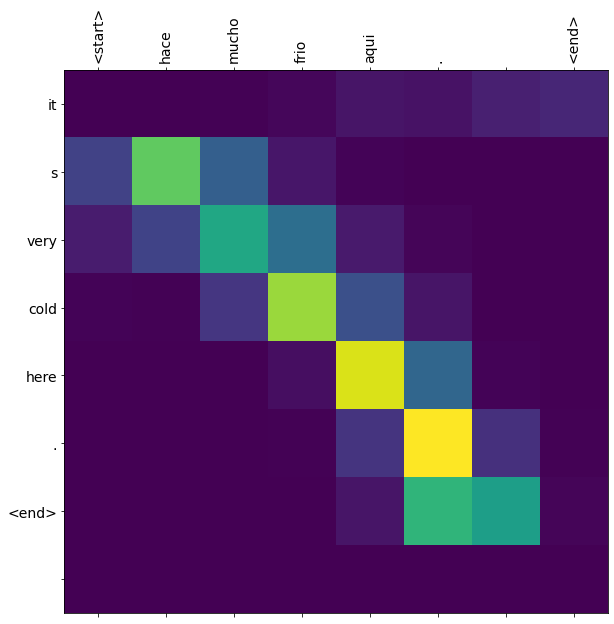

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
translate(u'hace mucho frio aqui.')


(1, 1024)
(1, 16, 1024)
(1, 16, 1024)
tf.Tensor(
[[[-7.3411616e-07  4.8006905e-09 -4.8359544e-07 ... -2.9854104e-07
   -1.1388031e-06  1.8559189e-07]
  [-1.4168079e-05 -7.7806374e-07  2.7188264e-07 ... -7.5522371e-07
   -1.0199008e-05 -1.7332964e-05]
  [-8.9980569e-03 -1.1991381e-04  4.6399643e-04 ... -6.7189854e-04
    5.4800916e-03  1.1404973e-02]
  ...
  [-4.8989967e-02  2.4937207e-03 -4.3055002e-02 ... -3.5703199e-03
    9.4241537e-02  5.4126870e-02]
  [-5.1547475e-02  2.4885584e-03 -4.3691102e-02 ... -3.7202835e-03
    9.4774522e-02  5.4432888e-02]
  [-5.4034896e-02  2.4796696e-03 -4.4234551e-02 ... -3.8667805e-03
    9.5160358e-02  5.4654520e-02]]], shape=(1, 16, 1024), dtype=float32)
(1, 1024)
tf.Tensor(
[[-0.46855104  0.02532005 -0.39978075 ... -0.03461288  0.9240943
   0.57326   ]], shape=(1, 1024), dtype=float32)
(1, 1, 256)
(1, 1, 1024)
(1, 1024)
(1, 1024)
(1, 16, 1024)
(1, 16, 1024)
tf.Tensor(
[[[-1.8018482e-03  1.1783034e-05 -1.1869587e-03 ... -7.3275273e-04
   -2.7951302e

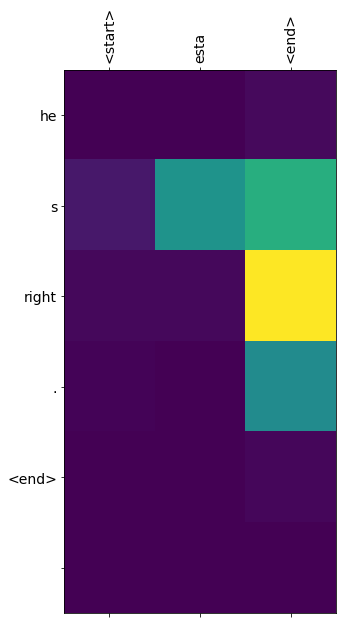

In [ ]:
translate('esta')

In [ ]:
translate(u'¿todavia estan en casa?')

KeyError: ignored

In [ ]:
translate(u'trata de averiguarlo.')